# Graph 

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
import matplotlib.pyplot as plt

In [2]:
from pkg.marker_config import *
init_kinect()
cameraMatrix, distCoeffs = get_calibration()
aruco_map, dictionary = get_aruco_config()

Device configuration: 
	color_format: 3 
	(0:JPG, 1:NV12, 2:YUY2, 3:BGRA32)

	color_resolution: 5 
	(0:OFF, 1:720p, 2:1080p, 3:1440p, 4:1536p, 5:2160p, 6:3072p)

	depth_mode: 3 
	(0:OFF, 1:NFOV_2X2BINNED, 2:NFOV_UNBINNED,3:WFOV_2X2BINNED, 4:WFOV_UNBINNED, 5:Passive IR)

	camera_fps: 2 
	(0:5 FPS, 1:15 FPS, 2:30 FPS)

	synchronized_images_only: False 
	(True of False). Drop images if the color and depth are not synchronized

	depth_delay_off_color_usec: 0 ms. 
	Delay between the color image and the depth image

	wired_sync_mode: 0
	(0:Standalone mode, 1:Master mode, 2:Subordinate mode)

	subordinate_delay_off_master_usec: 0 ms.
	The external synchronization timing.

	disable_streaming_indicator: False 
	(True or False). Streaming indicator automatically turns on when the color or depth camera's are in use.




In [5]:
while True:
    try:
        color_image = get_kinect_image()
        objectPose_dict, corner_dict = get_object_pose_dict(color_image, aruco_map, dictionary, cameraMatrix, distCoeffs)
        color_image_out = draw_objects(color_image, aruco_map, objectPose_dict, corner_dict, cameraMatrix, distCoeffs, axis_len=0.1)
        xyz_indy0, rpy_indy0 = T2xyzrpy(get_T_rel('floor', 'indy0', objectPose_dict))
        xyz_panda1, rpy_panda1 = T2xyzrpy(get_T_rel('floor', 'panda1', objectPose_dict))
        T_bc = SE3_inv(objectPose_dict['floor'])
        T_bo_0 = get_T_rel('floor', 'box1', objectPose_dict)
        xyz_cam, rvec_cam = T2xyzrvec(T_bc)
        xyz_box1, rvec_box1 = T2xyzrvec(T_bo_0)
        xyz_goal, rvec_goal = T2xyzrvec(get_T_rel('floor', 'goal', objectPose_dict))
        xyz_wall, rvec_wall = T2xyzrvec(get_T_rel('floor', 'wall', objectPose_dict))
        break
    except KeyError as e:
        print(e)
        break
    except Exception as e:
        print(e)
        pass

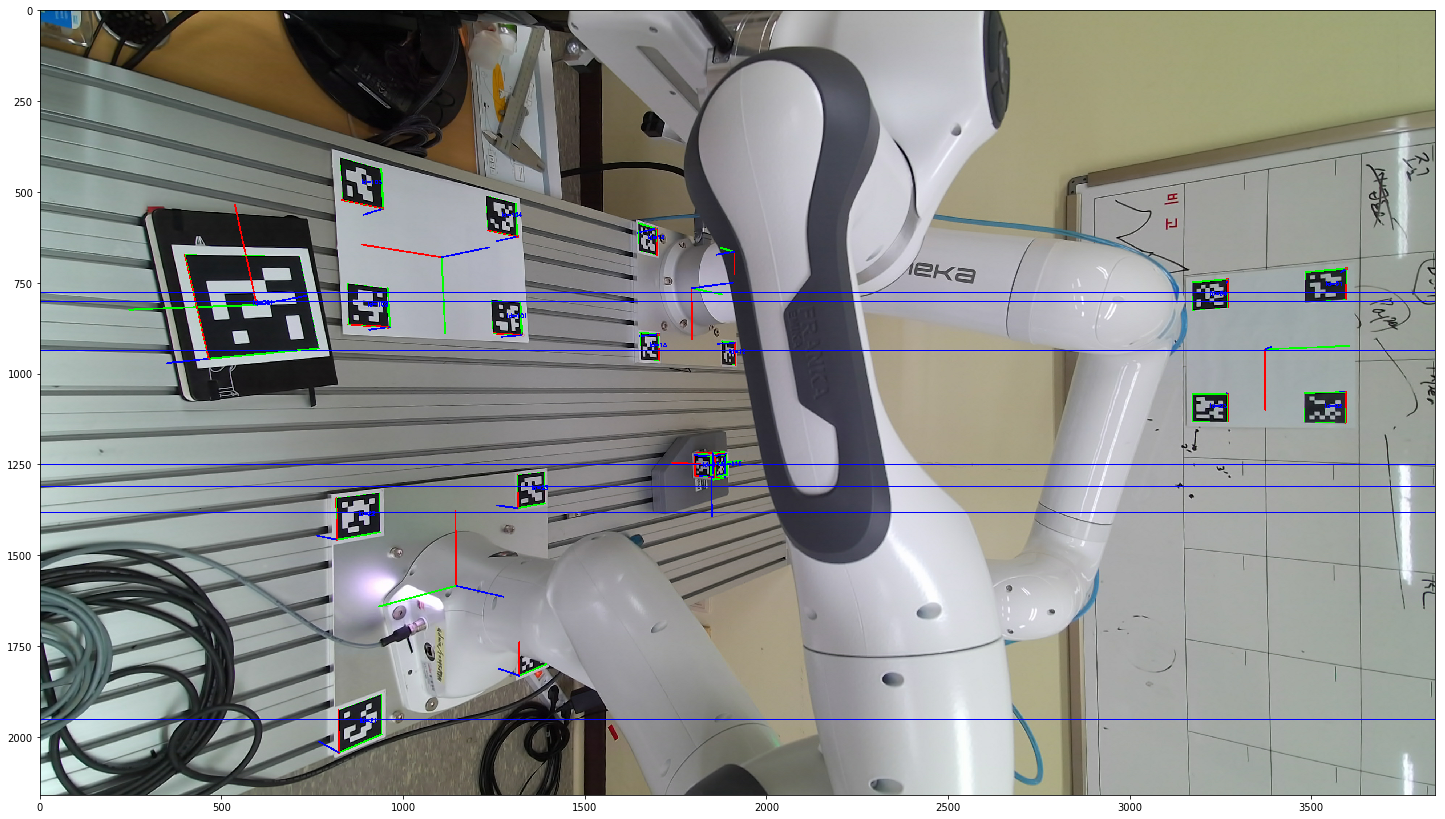

In [6]:
plt.figure(figsize=(25,15))
plt.imshow(color_image_out[:,:,[2,1,0]])

In [7]:
disconnect_kinect()

In [8]:
urdf_content = None
from pkg.robots_custom import *
xcustom = XacroCustomizer()
xcustom.clear()
# xcustom.add_robot(RobotType.indy7_robot, xyz=[0,-0.5,0], rpy=[0,0,0])
# xcustom.add_robot(RobotType.panda_robot, xyz=[0,0.5,0], rpy=[0,0,0])
xcustom.add_robot(RobotType.indy7_robot, xyz=xyz_indy0, rpy=rpy_indy0)
xcustom.add_robot(RobotType.panda_robot, xyz=xyz_panda1, rpy=rpy_panda1)
xcustom.write_xacro()
vel_scale = 1.0/2.0
effort_scale = 1.0/2.0
JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, urdf_content = \
        xcustom.convert_xacro_to_urdf(
        joint_fix_dict={'finger':'upper'},
        vel_limit_dict={k: v*vel_scale for k,v in {
            'panda1_joint1': np.deg2rad(150),  'panda1_joint2': np.deg2rad(150), 
            'panda1_joint3': np.deg2rad(150), 'panda1_joint4': np.deg2rad(150), 
            'panda1_joint5': np.deg2rad(180), 'panda1_joint6': np.deg2rad(180), 'panda1_joint7': np.deg2rad(180), 
            'indy0_joint0': np.deg2rad(150), 'indy0_joint1': np.deg2rad(150), 'indy0_joint2': np.deg2rad(150), 
            'indy0_joint3': np.deg2rad(180), 'indy0_joint4': np.deg2rad(180), 'indy0_joint5': np.deg2rad(180), 
        }.items()},
        effort_limit_dict={k: v*effort_scale for k,v in {
            'panda1_joint1': np.deg2rad(360),  'panda1_joint2': np.deg2rad(360), 
            'panda1_joint3': np.deg2rad(360), 'panda1_joint4': np.deg2rad(360), 
            'panda1_joint5': np.deg2rad(360), 'panda1_joint6': np.deg2rad(360), 'panda1_joint7': np.deg2rad(360), 
            'indy0_joint0': np.deg2rad(360), 'indy0_joint1': np.deg2rad(360), 'indy0_joint2': np.deg2rad(360), 
            'indy0_joint3': np.deg2rad(360), 'indy0_joint4': np.deg2rad(360), 'indy0_joint5': np.deg2rad(360), 
        }.items()}
    )
ZERO_JOINT_POSE=np.array([0,0,-np.pi/2,0,-np.pi/2,0,
                          0,-np.pi/8,0,-np.pi/2,0,np.pi/2,0])
refine_meshes()
xcustom.start_rviz()
    
from pkg.constraint_graph import *
from pkg.constants import *
import matplotlib.pyplot as plt
from pkg.plot_utils import *
from pkg.utils import *
# from threading import Thread, Lock
from multiprocessing import Process, Lock, Manager
PROC_MODE = True
rospy.init_node('task_planner', anonymous=True)

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


In [9]:
gtimer = GlobalTimer.instance()
gtimer.reset()
graph = ConstraintGraph(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, urdf_content=urdf_content,
                       connect_panda = True, connect_indy = True)
col_items_dict = graph.set_fixed_geometry_items(
    get_geometry_items_dict(graph.urdf_content, color=(0,1,0,0.5), display=True, collision=True, 
                             exclude_link=["panda1_link7"]))

Connect: Server IP (192.168.0.63)


# Custom Robots

In [10]:
gtimer.tic("set_scene")
collision=True
graph.add_geometry_items("world", 
                         [
                           GeoMesh(uri="package://my_mesh/meshes/stl/end_tool_asm_ctd.stl", BLH=(0.01,0.01,0.01), orientation_mat=Rot_axis(3,np.pi/16), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="indy0_tcp", 
                                   urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1), collision=False),
                           GeoBox(np.dot(Rot_axis(3,np.pi/16), (-0.055, 0,0.012)), (0.05,0.05,0.07), orientation=(0,0,np.pi/16), 
                                  name="gripper1_col", link_name="indy0_tcp", urdf_content=graph.urdf_content, color=(0,1,0,0.5), collision=collision),
                           GeoBox((0,0,-0.005), (3,3,0.01), name="floor", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
                           GeoBox(xyz_wall, (3,3,0.05),orientation=rvec_wall, name="wall", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
                           GeoBox(np.subtract(xyz_cam, [0,0,xyz_cam[2]/2]), 
                                  (0.1,0.1,xyz_cam[2]), 
                                  name="cam_pole", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
#                            GeoBox((0.4,0.4,0.15), (0.15,0.15,0.3), name="stepper", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1), collision=collision),
                           GeoBox(xyz_goal, (0.1,0.1,1e-3),orientation=rvec_goal, name="goal_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.0,0.0,1), collision=False)],
                         fixed=True)

graph.add_geometry_items("world", 
                         [GeoBox(xyz_box1, (0.05,0.05,0.05),orientation=rvec_box1, name="box1", link_name="world", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1), collision=collision)],
                         fixed=False)

graph.register_binder(name='grip1', _type=VacuumTool, point=[0,-2.5e-2,11e-2], link_name="panda1_hand", direction=[0,1,0])
graph.register_binder(name='vac2', _type=VacuumTool, point=[-0.055,0,0.048], link_name="indy0_tcp", direction=[0,0,1])
graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])
graph.register_binder(name='goal', _type=PlaceFrame, point=xyz_goal, orientation=rvec_goal, link_name="world")

box1_put_point = get_put_dir(Robj=Rotation.from_rotvec(rvec_box1).as_dcm(), dir_vec_dict=dir_vec_dict)+"_p"
graph.register_object('box1', _type=BoxAction, binding=(box1_put_point,"floor"), hexahedral=True)

graph.build_graph()
gtimer.toc("set_scene")
print("put_point: {}".format(box1_put_point))

put_point: right_p


# Set RVIZ

In [11]:
gtimer.tic("set_sim")
graph.set_simulation(nWSR=300, regularization_factor= 1e-6)
gtimer.toc("set_sim")
# graph.show_pose(ZERO_JOINT_POSE, execute=True)

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


In [12]:
if graph.connect_indy and graph.connect_panda:
    graph.show_pose(graph.get_real_robot_pose())
else:
    graph.show_pose(ZERO_JOINT_POSE)

# Search Graph (Custom Robots)

In [13]:
N_fullstep = 500
dt_sim = 0.02
gtimer.reset()
initial_state = State((('box1',box1_put_point,'floor'),), {'box1': T_bo_0}, 
                      graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda else ZERO_JOINT_POSE)
# goal_state = State((('box1',box1_put_point.replace('_p', '_f'),'goal'),), None, None)
goal_state = State((('box1','right_f','goal'),), None, None)
graph.search_graph_mp(
    initial_state = initial_state, goal_state = goal_state,
    tree_margin = 4, depth_margin = 2, joint_motion_num=10, 
    terminate_on_first = True, N_search = 100, N_loop=1000,
    display=False, dt_vis=dt_sim, verbose = True, print_expression=False,
    **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-2, err_conv=1e-3, N_step=N_fullstep))
print(gtimer)


success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (0.35 s, err: 0.000955805437288)
node: (('box1', 'right_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->2 (0.59 s, err: 0.000998682484797)
node: (('box1', 'right_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->4 (0.71 s, err: 0.000970208815467)
node: (('box1', 'right_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->3 (0.72 s, err: 0.000986542455014)======================================================================================================================================================

node: (('box1', 'right_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->5 (0.91 s, err: 0.000920379671741)
node: (('box1', 'right_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)

success - Goal cost:2->1 / I

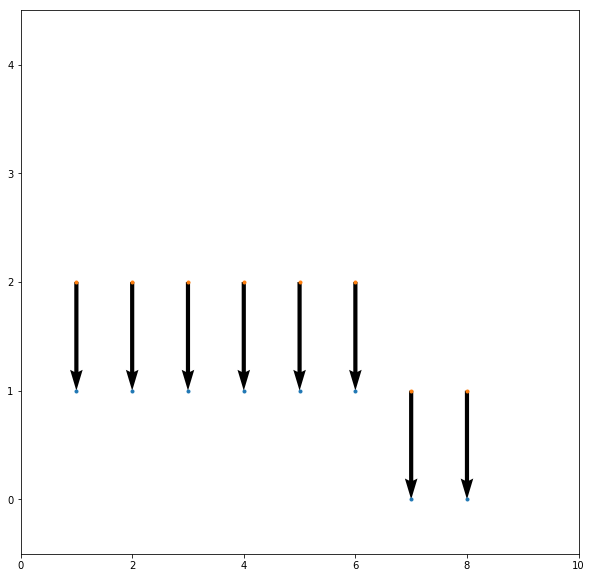

In [14]:
graph.quiver_snodes()

# Replay schedule

In [15]:
schedule_dict = graph.find_schedules()
schedule_sorted = graph.sort_schedule(schedule_dict)
N_fullstep = 500
dt_vis = 0.01
for schedule in schedule_sorted:
    print(schedule)
for schedule, i_s in zip(schedule_sorted, range(len(schedule_sorted))):
    e, end_state, success = graph.simulate_transition(
        graph.snode_dict[0].state, graph.snode_dict[0].state, 
        N=10, dt=0.01, vel_conv=1e-2, err_conv=5e-4)
    timer.sleep(0.1)
#     try:
    e = graph.replay(schedule, N=N_fullstep, dt=dt_vis, N_step=N_fullstep, 
                     vel_conv=1e-2, err_conv=5e-4, error_skip=0)
#     except Exception as e:
#         print(e)

[0, 2, 8]
[0, 3, 7]

--------------------
2-(('box1', 'top_p', 'vac2'),)

--------------------
8-(('box1', 'right_f', 'goal'),)

--------------------
3-(('box1', 'front_p', 'vac2'),)

--------------------
7-(('box1', 'right_f', 'goal'),)


# test get indy traj

In [16]:
gtimer.reset()

schedule = schedule_sorted[0]
control_freq_indy, playback_speed_log2 = 4e3, 1
playback_speed = 2**playback_speed_log2

e_POS_list = []
    
from_Q = graph.snode_dict[schedule[0]].state.Q
for i_s in range(len(schedule)-1):
    from_state = graph.snode_dict[schedule[i_s]].state
    from_state.Q = from_Q
    to_state = graph.snode_dict[schedule[i_s+1]].state
    kwargs = dict(vel_conv=0, err_conv=5e-4)
    e_POS, dt, succ = graph.get_traj(from_state, to_state, control_freq=control_freq_indy, 
            T_step=10, downsample_log2=4, playback_speed_log2=playback_speed_log2, 
             **kwargs)
    e_POS_list.append(e_POS)
    from_Q = e_POS[-1]
#     print(gtimer)
    print(succ)

250.0 Hz / 10.0 sec : 2500
True
250.0 Hz / 10.0 sec : 2500
False


In [17]:
for e_POS in e_POS_list:
    graph.show_motion(e_POS[::50], error_skip=0)

In [18]:
e_POS = e_POS_list[0]
if hasattr(graph, 'indy'):
    graph.indy.joint_move_to(np.rad2deg(e_POS[0,graph.indy_idx]))

In [19]:
# if hasattr(graph, 'indy'):
#     graph.indy.stop_motion()

In [20]:
# # External trajectory move with text data
# if hasattr(graph, 'indy'):
#     gtimer.reset()
#     traj_type=1
#     traj_freq=4000
#     dat_size=6
#     traj_data_list = graph.get_traj_dat(e_POS[:,graph.indy_idx], dt=dt)
#     graph.indy.move_ext_traj_txt(traj_type=traj_type, traj_freq=traj_freq, dat_size=dat_size, 
#                                  traj_data=traj_data_list)
#     del traj_data_list

In [21]:
# if hasattr(graph, 'indy'):
#     graph.indy.stop_motion()

# sync panda 

In [22]:
from etasl_py.etasl import dict_to_array, array_to_dict

In [97]:
gtimer.reset()

self = graph
schedule = schedule
e_POS_list = e_POS_list
control_freq_indy = control_freq_indy
playback_speed = playback_speed
control_freq_panda = 100
indy_traj_delay = 1e-1
move_robot = True
max_err_count = 10

In [99]:
i_s = 1
gtimer.tic("init_param")
from_state = self.snode_dict[schedule[i_s]].state
from_state.Q = from_Q if i_s>0 else self.snode_dict[schedule[0]].state.Q
to_state = self.snode_dict[schedule[i_s+1]].state
e_POS = e_POS_list[i_s]
# kf = createKF(graph.joint_num, dt=1.0/control_freq_panda, P=1000, R=5, Q=0.1, 
#               X0=augment_jvals_dot(from_Q))
gtimer.toc("init_param")

# downsample trajectory
gtimer.tic("downsample")
e_POS_fl = e_POS[::int(control_freq_indy/control_freq_panda), :]
e_POS_fl_indy = e_POS_fl[:, self.indy_idx]
e_POS_fl_panda = e_POS_fl[:, self.panda_idx]
gtimer.toc("downsample")

gtimer.tic("prepare_memory")
inp = e_POS_fl_indy
N_panda = len(inp)

gtimer.toc("prepare_memory")

gtimer.tic("init_etasl")
e_sim, pos = self.init_panda_sync_indy(from_state, to_state, N_panda, 
                                       control_freq_panda=control_freq_panda*playback_speed, K_sync_indy=100)
gtimer.toc("init_etasl")

gtimer.tic("get_traj_dat")
traj_delay = np.tile(e_POS[0:1,:len(self.indy_idx)], 
                     [int(control_freq_indy*indy_traj_delay),1])
traj_type, traj_freq, dat_size = 1, 4000, 6
traj_data_list = graph.get_traj_dat(
    np.concatenate([traj_delay, e_POS[:,self.indy_idx]],axis=0), dt=dt)
gtimer.toc("get_traj_dat")
if move_robot:
    gtimer.tic("move_ext_traj_txt")
    graph.indy.move_ext_traj_txt(traj_type=traj_type, 
                                 traj_freq=traj_freq, dat_size=dat_size, 
                                 traj_data=traj_data_list)
    gtimer.toc("move_ext_traj_txt")
    
error_count = 0
POS_CUR = from_state.Q
VEL_CUR = np.zeros_like(POS_CUR)
end_loop = False
for i_sim in range(len(e_sim.TIME)):
    gtimer.tic("simulate_step")
    gtimer.tic("predict")
#     kf.predict()
    gtimer.toc("predict")
    try:
        pos = e_sim.simulate_step(i_sim, pos, dt=None, 
                                  inp_cur=inp[i_sim], inpvel_cur=None)        
        VEL_CUR = VEL_CUR+e_sim.VEL[i_sim,1::2] * e_sim.DT
        POS_CUR = POS_CUR + VEL_CUR * e_sim.DT
        gtimer.tic("update")
#         kf.update(dict_to_array(pos, self.joint_names))
        gtimer.toc("update")
    except EventException:
        end_loop = True
    except Exception as e:
        error_count += 1
        print("ERROR {}: {}".format(error_count, e))
        if error_count > max_err_count:
            print("MAX ERROR REACHED {}".format(error_count))
            raise(e)
#         pos = array_to_dict(kf.x, self.pos_lbl)
        POS_CUR = dict_to_array(pos, self.joint_names)
    pos_arr = POS_CUR
    pos_panda = pos_arr[self.panda_idx]
    self.panda.rate.sleep()
    if move_robot:
        self.panda.send_qval(pos_panda)
    gtimer.toc("simulate_step")
    if end_loop:
        break
from_Q = pos_arr
from_Q[self.indy_idx] = e_POS[-1,self.indy_idx]
del traj_data_list

In [100]:
print(gtimer)

init_param: 	2.0 ms/2 = 0.776 ms (0.754117965698/0.797033309937)
downsample: 	0.0 ms/2 = 0.224 ms (0.134229660034/0.31304359436)
prepare_memory: 	0.0 ms/2 = 0.07 ms (0.0450611114502/0.0948905944824)
init_etasl: 	141.0 ms/2 = 70.491 ms (69.8881149292/71.093082428)
get_transition_context: 	2.0 ms/2 = 0.905 ms (0.736951828003/1.07312202454)
set_object_state: 	0.0 ms/2 = 0.248 ms (0.229835510254/0.267028808594)
start get_tf_text: 	1.0 ms/2 = 0.44 ms (0.365018844604/0.514984130859)
start get_collision_text: 	0.0 ms/2 = 0.091 ms (0.0650882720947/0.117063522339)
start make_constraints: 	0.0 ms/2 = 0.069 ms (0.0331401824951/0.103950500488)
get_traj_dat: 	41.0 ms/4 = 10.161 ms (3.42512130737/16.8828964233)
move_ext_traj_txt: 	6427.0 ms/2 = 3213.633 ms (1156.27884865/5270.98798752)
simulate_step: 	23673.0 ms/2369 = 9.993 ms (5.52606582642/16.1888599396)
predict: 	2.0 ms/2369 = 0.001 ms (0.0/0.0159740447998)
update: 	4.0 ms/2369 = 0.002 ms (0.0/0.0200271606445)



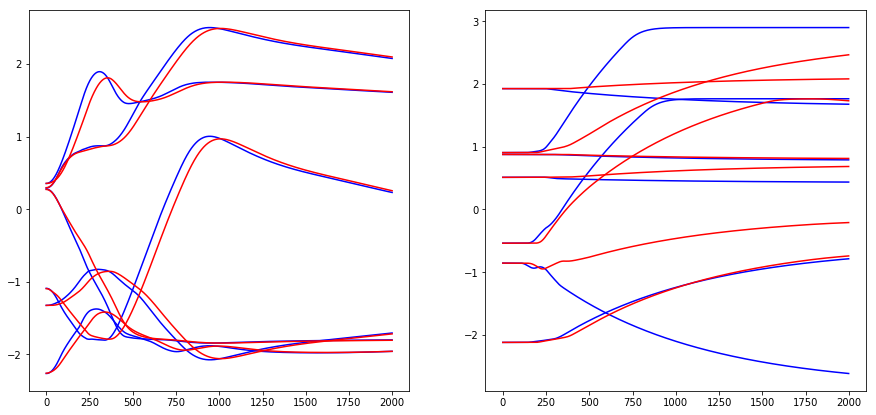

In [31]:
POS_list = integrate(integrate(e_sim.VEL[:,1::2], e_sim.DT), e_sim.DT, 
                     X0=e_sim.POS[0, ::2])
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
ax = plt.plot(e_POS_fl_indy, '-b')
ax = plt.plot(POS_list[:,graph.indy_idx], '-r')
plt.subplot(1,2,2)
ax = plt.plot(e_POS_fl_panda, '-b')
ax = plt.plot(POS_list[:,graph.panda_idx], '-r')

In [34]:
graph.show_motion(POS_list, period=1e-2, error_skip=0)

# Going back

In [133]:
e_POS = e_POS_list[0]
self.panda.move_joint_interpolated(
    e_POS[0, graph.panda_idx], N_step=500, N_div=500)

In [35]:
e_POS = e_POS_list[0]
if hasattr(graph, 'indy'):
    graph.indy.joint_move_to(np.rad2deg(e_POS[0,graph.indy_idx]))

In [101]:
newpppp = POS_list.copy()

In [102]:
newpppp[:,graph.panda_idx] = pos_panda_list

In [38]:
self.reset_panda()